In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import matplotlib.pylab as plt
import cv2
import numpy as np

from estimation.config import get_default_configuration
from estimation.coordinates import get_coordinates
from estimation.connections import get_connections
from estimation.estimators import estimate
from estimation.renderers import draw

tflite_model_file = 'tflite/0629_epoch300/openpose_singlenet.tflite'
test_image = 'resources/ski_224.jpg'
output_image = "tflite_demo.png"

interpreter = tf.lite.Interpreter(model_path=tflite_model_file)

inp_details = interpreter.get_input_details()
out_details = sorted(interpreter.get_output_details(), key=lambda k: k['index']) 

print("[tflite details]:\n--------------------------------------------------")
tf.print("inp_details:", type(inp_details), "\n\n", inp_details, end="\n--------------------------------------------------\n")
tf.print("out_details: ", type(out_details), "\n\n", out_details)

#for i in range(0, len(out_details)):
#    print(out_details[i], end="\n\n")

inp_index = interpreter.get_input_details()[0]["index"]  # 0,   0
out_index = interpreter.get_output_details()[0]["index"] # 611, 604
paf_idx = out_details[-2]["index"]                       # 757, 748 
heatmap_idx = out_details[-1]["index"]                   # 830, 820

[tflite details]:
--------------------------------------------------
inp_details: <class 'list'> 

 [{'dtype': <class 'numpy.uint8'>,
  'index': 0,
  'name': 'input_1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
                              'scales': array([], dtype=float32),
                              'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([ -1, 224, 224,   3], dtype=int32),
  'sparsity_parameters': {}}]
--------------------------------------------------
out_details:  <class 'list'> 

 [{'dtype': <class 'numpy.float32'>,
  'index': 604,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
                              'scales': array([], dtype=float32),
                              'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 28, 28, 38], dtype=int32),
  'shape_signature': array([-1, 28, 28,

# Load sample image and run the model

In [2]:
img = cv2.imread(test_image)     # B,G,R order, shape:(224, 224, 3)
# plt.imshow(img[:,:,[2,1,0]])

img = np.expand_dims(img, 0)     # shape(1, 224, 224, 3)
# plt.imshow(img[0,:,[2,1,0]])

In [3]:
# img convert to 8 units tensor format.
input_tensor= tf.convert_to_tensor(img, np.uint8)

# Allocate_tensors() avoids making a numpy array directly. 
interpreter.allocate_tensors()
interpreter.set_tensor(inp_index, input_tensor)
interpreter.invoke()

heatmaps = interpreter.get_tensor(heatmap_idx)
pafs = interpreter.get_tensor(paf_idx)

print("input_tensor: {}, shape: {}".format(type(input_tensor), input_tensor.shape))
print("heatmaps: {}, shape: {}".format(type(heatmaps), heatmaps.shape))
print("pafs:     {}, shape: {}".format(type(pafs), pafs.shape))

input_tensor: <class 'tensorflow.python.framework.ops.EagerTensor'>, shape: (1, 224, 224, 3)
heatmaps: <class 'numpy.ndarray'>, shape: (1, 28, 28, 19)
pafs:     <class 'numpy.ndarray'>, shape: (1, 28, 28, 38)


In [4]:
print("heatmaps:\n\n", heatmaps)
print("pafs:\n\n", pafs)

heatmaps:

 [[[[-2.02821172e-03  1.88103947e-03  3.58038116e-03 ...  8.24435439e-04
     2.21237264e-04  9.74004149e-01]
   [ 1.31941354e-03  2.85884860e-04  1.29599497e-03 ... -1.36003422e-03
     2.63762521e-03  9.85760689e-01]
   [ 1.25082012e-03 -3.25936358e-04 -2.40461715e-03 ... -1.58291613e-03
     6.38541125e-04  9.97743785e-01]
   ...
   [ 8.46159682e-02 -4.41533281e-03 -2.41086283e-03 ...  1.43974861e-02
     1.58072039e-01  7.33472228e-01]
   [ 1.52721107e-02 -2.58125016e-03 -2.79810000e-03 ...  6.78879966e-04
     9.48485211e-02  8.85212064e-01]
   [ 5.79008693e-03  4.87937778e-03  1.64263453e-02 ...  8.17157701e-03
     2.24946649e-03  9.55318511e-01]]

  [[ 6.95348426e-04  3.07982235e-04  3.66626051e-03 ...  1.50217826e-03
     1.51024247e-03  9.61092353e-01]
   [ 2.69666058e-03  1.40870793e-03 -1.82688446e-03 ... -1.51923555e-03
     1.08631473e-04  9.65159774e-01]
   [ 8.23120354e-04  7.19545933e-04  1.10862216e-04 ...  8.22161150e-04
    -5.29909630e-06  9.77058470e-01

In [5]:
    print("heatmaps[0,0,:]:\n\n{}\n\n".format(heatmaps[0,0,0,:]))
    print("pafs[0,0,:]:\n\n{}\n\n".format(pafs[0,0,0,:]))

heatmaps[0,0,:]:

[-2.0282117e-03  1.8810395e-03  3.5803812e-03  2.6921725e-03
 -8.6006295e-04  1.6180236e-03  2.4151537e-03 -2.1876765e-05
  8.8381190e-03  3.6120145e-03  6.6728372e-04  2.2710690e-03
  1.4326782e-03  4.6625265e-04  1.1067274e-03 -3.1231840e-03
  8.2443544e-04  2.2123726e-04  9.7400415e-01]


pafs[0,0,:]:

[ 0.00144376 -0.00056277  0.00416949  0.00522244  0.0006007   0.0020206
  0.00133534  0.000511   -0.00010623  0.00350024  0.00313611  0.00191944
  0.00148558  0.00143278  0.0017114   0.00127691  0.0006272   0.00142318
  0.00171207  0.00303733  0.00391059 -0.00037191 -0.00211491 -0.00370772
 -0.00018802  0.00153625 -0.00164774  0.00131994 -0.00148108  0.00065809
 -0.00157267  0.00073571  0.000181   -0.00188722  0.00248824  0.00042995
 -0.00289715 -0.00185204]




In [7]:
    print("heatmaps[0,0,:]:\n\n{}\n\n".format(heatmaps[:,0,0,:]))

heatmaps[0,0,:]:

[-2.0282117e-03  1.8810395e-03  3.5803812e-03  2.6921725e-03
 -8.6006295e-04  1.6180236e-03  2.4151537e-03 -2.1876765e-05
  8.8381190e-03  3.6120145e-03  6.6728372e-04  2.2710690e-03
  1.4326782e-03  4.6625265e-04  1.1067274e-03 -3.1231840e-03
  8.2443544e-04  2.2123726e-04  9.7400415e-01]




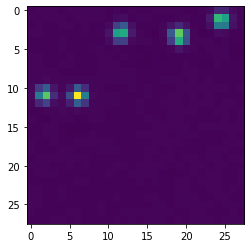

In [6]:
heatmap_idx = 0 # nose

plt.imshow(heatmaps[0, :, :, heatmap_idx])

In [17]:
# 07/05, np remove a dimension from np array.
# heatmaps = heatmaps[0, :, :, :]
# pafs = pafs[0, :, :, :]

# print("heatmaps: {}, shape: {}".format(type(heatmaps), heatmaps.shape))
# print("pafs:     {}, shape: {}".format(type(pafs), pafs.shape))

print("heatmaps:\n\n", heatmaps)
print("pafs:\n\n", pafs)

heatmaps:

 [[[[-2.02821172e-03  1.88103947e-03  3.58038116e-03 ...  8.24435439e-04
     2.21237264e-04  9.74004149e-01]
   [ 1.31941354e-03  2.85884860e-04  1.29599497e-03 ... -1.36003422e-03
     2.63762521e-03  9.85760689e-01]
   [ 1.25082012e-03 -3.25936358e-04 -2.40461715e-03 ... -1.58291613e-03
     6.38541125e-04  9.97743785e-01]
   ...
   [ 8.46159682e-02 -4.41533281e-03 -2.41086283e-03 ...  1.43974861e-02
     1.58072039e-01  7.33472228e-01]
   [ 1.52721107e-02 -2.58125016e-03 -2.79810000e-03 ...  6.78879966e-04
     9.48485211e-02  8.85212064e-01]
   [ 5.79008693e-03  4.87937778e-03  1.64263453e-02 ...  8.17157701e-03
     2.24946649e-03  9.55318511e-01]]

  [[ 6.95348426e-04  3.07982235e-04  3.66626051e-03 ...  1.50217826e-03
     1.51024247e-03  9.61092353e-01]
   [ 2.69666058e-03  1.40870793e-03 -1.82688446e-03 ... -1.51923555e-03
     1.08631473e-04  9.65159774e-01]
   [ 8.23120354e-04  7.19545933e-04  1.10862216e-04 ...  8.22161150e-04
    -5.29909630e-06  9.77058470e-01

In [6]:
cfg = get_default_configuration()

In [7]:
coordinates = get_coordinates(cfg, heatmaps)
print("coordinates type:", type(coordinates), end="\n\n")
# print(coordinates['left_hip'])

for i, (k, v) in enumerate(coordinates.items(), 0):
    print("[{}] {}: {}\n".format(i, k, v))
    # print("{}, {}\n".format(i, k))
    # print("{}, {}\n".format(k, v))

coordinates type: <class 'dict'>

[0] nose: [(0, 0, array([-2.0282117e-03,  1.8810395e-03,  3.5803812e-03,  2.6921725e-03,
       -8.6006295e-04,  1.6180236e-03,  2.4151537e-03, -2.1876765e-05,
        8.8381190e-03,  3.6120145e-03,  6.6728372e-04,  2.2710690e-03,
        1.4326782e-03,  4.6625265e-04,  1.1067274e-03, -3.1231840e-03,
        8.2443544e-04,  2.2123726e-04,  9.7400415e-01], dtype=float32), 0), (2, 0, array([-1.1136334e-03, -1.2996021e-03, -1.3084864e-03,  1.1165373e-03,
        2.0283838e-03, -1.2304362e-05,  2.7275109e-03,  3.5221593e-03,
        6.7920936e-03,  1.7473138e-03,  8.4008626e-04,  4.6307514e-03,
        5.1191347e-03,  5.0325686e-04,  1.3027621e-03,  1.8994468e-03,
        6.9934869e-04, -2.3448501e-04,  9.7003597e-01], dtype=float32), 1), (7, 0, array([ 1.2898243e-03,  6.6706463e-04, -1.4989821e-03, -7.0321042e-04,
       -2.3531134e-06,  1.0532533e-03,  2.3049100e-03,  9.0059353e-04,
        2.5770455e-03,  3.0223804e-03,  7.8824547e-04,  1.1391076e-03,
 

In [16]:
connections = get_connections(cfg, coordinates, pafs).all()
print("connections: {}, len: {}\n\n {}\n".format(type(connections), len(connections), connections))

for i in range(0, len(connections)):
    print(connections[i], end="\n\n")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [15]:
skeletons = estimate(cfg, connections)
print("skeletons: {}, shape: {}, len: {}\n\n {}".format(type(skeletons), skeletons.shape, len(skeletons), skeletons))

skeletons: <class 'numpy.ndarray'>, shape: (0, 20), len: 0

 []


In [16]:
output = draw(cfg, img, coordinates, skeletons, resize_fac=8)
print("output: {}, shape: {}, len: {}\n\n {}".format(type(output), output.shape, len(output), output))

output: <class 'numpy.ndarray'>, shape: (1, 224, 224, 3), len: 1

 [[[[ 12  13   9]
   [ 20  22  16]
   [ 20  22  16]
   ...
   [ 17  23  22]
   [ 17  23  22]
   [ 18  23  22]]

  [[ 11  12   8]
   [ 19  21  15]
   [ 17  21  15]
   ...
   [ 21  26  25]
   [ 21  26  25]
   [ 20  25  24]]

  [[ 10  11   7]
   [ 17  19  13]
   [ 23  25  19]
   ...
   [ 23  28  27]
   [ 23  28  27]
   [ 23  28  27]]

  ...

  [[159 172 170]
   [160 173 171]
   [159 172 170]
   ...
   [158 172 170]
   [152 170 169]
   [157 171 170]]

  [[159 172 170]
   [158 171 169]
   [157 170 168]
   ...
   [154 168 167]
   [153 167 166]
   [154 166 166]]

  [[159 172 170]
   [157 170 168]
   [158 171 169]
   ...
   [153 167 166]
   [154 166 166]
   [152 166 165]]]]


In [17]:
cv2.imwrite(output_image, output)
print(f"Output saved: {output_image}")

Output saved: tflite_demo.png


# Show predictions: paf and heatmap

In [18]:
heatmap_idx = 0 # nose
# cmap: 顏色圖譜（colormap），默認繪製為RGB（A）顏色空間。 
# plt.imshow(heatmaps[0, :, :, heatmap_idx], cmap='gray')
plt.imshow(heatmaps[0, :, :, heatmap_idx])

IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

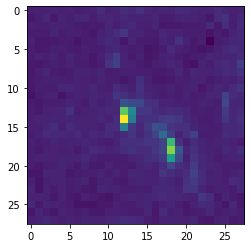

In [21]:
plt.imshow(pafs[0, :, :,5])

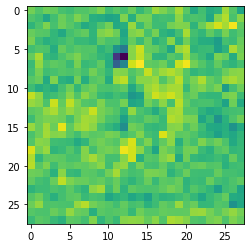

In [18]:
paf_dx_idx = 0
paf_dy_idx = 1

# plt.imshow(pafs[0, :, :, paf_dx_idx], cmap='gray')
plt.imshow(pafs[0, :, :, paf_dx_idx])


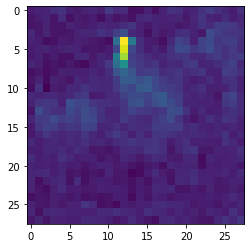

In [19]:
# plt.imshow(pafs[0, :, :, paf_dy_idx], cmap='gray')
plt.imshow(pafs[0, :, :, paf_dy_idx])